# Using `PacMan`

This notebook contains examples on how to use the class `PacMan`.

In [1]:
from pytket import Circuit
from pytket.circuit import OpType, Op
from pytket.circuit.display import render_circuit_jupyter
from pytket_dqc.networks import NISQNetwork
from pytket_dqc.allocators import HypergraphPartitioning
from pytket_dqc.circuits import HypergraphCircuit
from pytket_dqc.packing import PacMan
from pytket_dqc.utils import DQCPass
from pytket_dqc.placement import Placement
from sympy import Symbol
import networkx as nx

To demonstrate various capabilities, we construct the below dummy circuit and placement.

In [2]:
test_circuit = Circuit(6)
# This test circuit is comprised of sections
# designed to test various things

# Test that hyperedges on different servers are split
# Test that hyperedges split by (anti)diagonal gates
# are merged
cz = Op.create(OpType.CU1, 1)
test_circuit.add_gate(cz, [0,2])
test_circuit.add_gate(cz, [0,4])
test_circuit.Z(0).X(0)
test_circuit.add_gate(cz, [0,5])
test_circuit.add_gate(cz, [0,3])

# Test we can embed two CU1s with no Hadamard
# one Hadamard and two Hadamards
# S gates inserted to ensure angle of phase gates
# sum to integer
test_circuit.H(0)
test_circuit.Rz(0.5, 0)
test_circuit.add_gate(cz, [0,2])
test_circuit.Rz(0.5, 0) # 0 H
test_circuit.add_gate(cz, [0,3])
test_circuit.H(0) # 1 H
test_circuit.add_gate(cz, [0,2]) # NOT mergeable
test_circuit.Rz(0.5, 0)
test_circuit.H(0) # 2 H
test_circuit.Rz(0.27, 0) # Random phase that should have no effect
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2])
test_circuit.H(0)
test_circuit.add_gate(cz, [0,3]) # This gate is mergeable

# Test that local and 3rd party server CU1s break embeddability
test_circuit.H(0)
test_circuit.add_gate(cz, [0,1]) # Local CU1
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2]) # NOT mergeable
test_circuit.H(0)
test_circuit.add_gate(cz, [0,4]) # 3rd party CU1
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2]) # NOT mergeable

# Test that conflicts are identified correctly
test_circuit.H(0).H(2)
test_circuit.add_gate(cz, [0,2])
test_circuit.H(0).H(2)
test_circuit.add_gate(cz, [0,2])

placement_dict = {
    0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2,
}
for i in range(6, 19):
    placement_dict[i] = 0
placement = Placement(placement_dict)

hyper_circ = HypergraphCircuit(test_circuit)

Here's how the circuit looks.

In [3]:
render_circuit_jupyter(test_circuit)

To use `PacMan`, simply pass in the `HypergraphCircuit` and `Placement`.

In [4]:
pacman = PacMan(hyper_circ, placement)

Graph methods are often useful for visual checks. We can use the method `.get_nx_graph_merged()` to return a graph representation of the circuit.

Note that this method also returns all the nodes on one half of the bipartite graph (conventionally called the top half). This is because the graph is likely highly disconnected, so `NetworkX` requires this to avoid ambiguous solutions to certain methods.

In [5]:
g, topnodes = pacman.get_nx_graph_merged()
print(nx.adjacency_matrix(g).toarray())

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]]


/var/folders/7m/9npf2gm93r9gg6_1lz__10km0000gn/T/ipykernel_5569/299496484.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(g).toarray())


This can be easily drawn as a bipartite graph like so (note this is an example of needing `topnodes`).

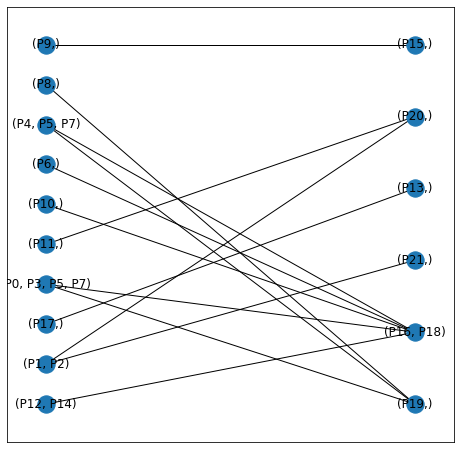

In [6]:
nx.draw_networkx(
    g,
    pos = nx.drawing.layout.bipartite_layout(g, topnodes), 
    width = 1)

We can also get and draw the conflict graph.

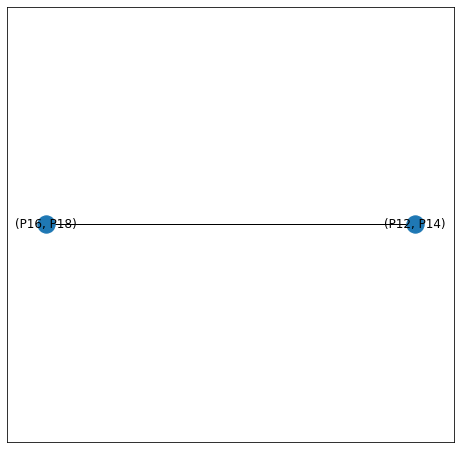

In [7]:
conflict_g, conflict_topnodes = pacman.get_nx_graph_conflict()
nx.draw_networkx(
    conflict_g,
    pos = nx.drawing.layout.bipartite_layout(conflict_g, conflict_topnodes), 
    width = 1)

For our purposes, it is useful to obtain a minimum vertex cover of the merged graph, as well as find out which vertices of the MVC also form conflicting edges (here, the conflicting edge does not represent a true conflict).

In [8]:
print(pacman.get_mvc_merged_graph())

{(P19,), (P11,), (P1, P2), (P17,), (P16, P18), (P9,)}


## More complex circuit (under construction)

We now import a Chemistry circuit as a real world example.

In [9]:
import json
# Replace this with the location of the Chemistry circuit.
with open("../../Tokyo-CQC-collab/circuits/uccsd/raw/06_02_01.json") as f:
    circuit = Circuit.from_dict(json.load(f))
network = NISQNetwork(
    [[0,1]],
    {0: [0,1,2], 1: [3,4,5]}
)

# Bind all the symbols in the circuit
t01 = Symbol("t0_1")
t02 = Symbol("t0_2")
t11 = Symbol("t1_1")
t12 = Symbol("t1_2")
t22 = Symbol("t2_2")
t21 = Symbol("t2_1")
t31 = Symbol("t3_1")
t41 = Symbol("t4_1")
t51 = Symbol("t5_1")
t61 = Symbol("t6_1")
t71 = Symbol("t7_1")

symbols = [
    t01, t02, t11, t12, t22, t21, t31, t41, t51, t61, t71
]

symbol_map = dict()

for symbol in symbols:
    symbol_map[symbol] = 0

circuit.symbol_substitution(symbol_map)
render_circuit_jupyter(circuit)

# Check they're all bound
assert len(circuit.free_symbols()) == 0

In [10]:
DQCPass().apply(circuit)
allocator = HypergraphPartitioning()
distribution = allocator.allocate(circuit, network)
hypergraph_circuit = HypergraphCircuit(circuit)
render_circuit_jupyter(circuit)

In [11]:
pacman_chem = PacMan(hypergraph_circuit, distribution.placement)
g_chem, topnodes_chem = pacman_chem.get_nx_graph_merged()
conflict_g_chem, conflict_topnodes_chem = pacman_chem.get_nx_graph_conflict()

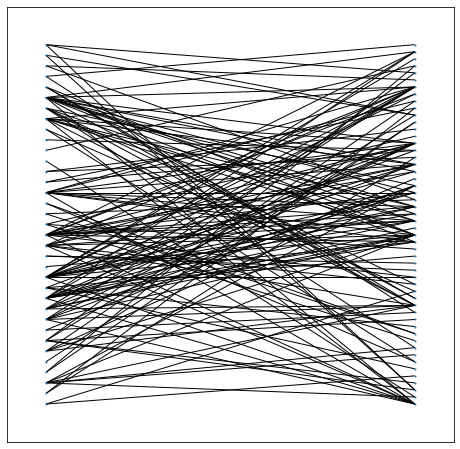

In [12]:
nx.draw_networkx(
    g_chem,
    pos = nx.drawing.layout.bipartite_layout(g_chem, topnodes_chem), 
    width = 1,
    node_size=1,
    with_labels=False
)

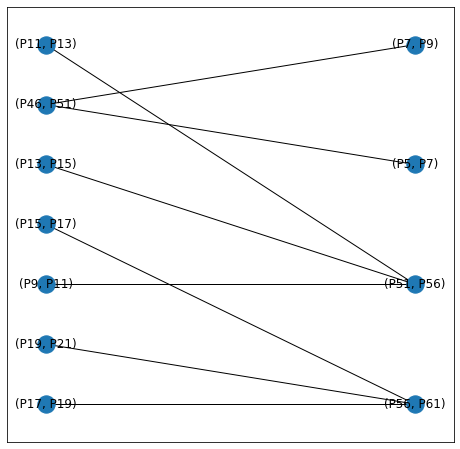

In [13]:
nx.draw_networkx(
    conflict_g_chem,
    pos = nx.drawing.layout.bipartite_layout(conflict_g_chem, conflict_topnodes_chem), 
    width = 1)